용량 제약이 있는 차량 라우팅 문제

In [7]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

def create_data_model():
    """Stores the data for the problem."""
    data = {}
    # 거리 행렬 정의 (노드 간 거리)
    data["distance_matrix"] = [
        [0, 548, 776, 696, 582, 274, 502, 194, 308, 194, 536, 502, 388, 354, 468, 776, 662],
        [548, 0, 684, 308, 194, 502, 730, 354, 696, 742, 1084, 594, 480, 674, 1016, 868, 1210],
        [776, 684, 0, 992, 878, 502, 274, 810, 468, 742, 400, 1278, 1164, 1130, 788, 1552, 754],
        [696, 308, 992, 0, 114, 650, 878, 502, 844, 890, 1232, 514, 628, 822, 1164, 560, 1358],
        [582, 194, 878, 114, 0, 536, 764, 388, 730, 776, 1118, 400, 514, 708, 1050, 674, 1244],
        [274, 502, 502, 650, 536, 0, 228, 308, 194, 240, 582, 776, 662, 628, 514, 1050, 708],
        [502, 730, 274, 878, 764, 228, 0, 536, 194, 468, 354, 1004, 890, 856, 514, 1278, 480],
        [194, 354, 810, 502, 388, 308, 536, 0, 342, 388, 730, 468, 354, 320, 662, 742, 856],
        [308, 696, 468, 844, 730, 194, 194, 342, 0, 274, 388, 810, 696, 662, 320, 1084, 514],
        [194, 742, 742, 890, 776, 240, 468, 388, 274, 0, 342, 536, 422, 388, 274, 810, 468],
        [536, 1084, 400, 1232, 1118, 582, 354, 730, 388, 342, 0, 878, 764, 730, 388, 1152, 354],
        [502, 594, 1278, 514, 400, 776, 1004, 468, 810, 536, 878, 0, 114, 308, 650, 274, 844],
        [388, 480, 1164, 628, 514, 662, 890, 354, 696, 422, 764, 114, 0, 194, 536, 388, 730],
        [354, 674, 1130, 822, 708, 628, 856, 320, 662, 388, 730, 308, 194, 0, 342, 422, 536],
        [468, 1016, 788, 1164, 1050, 514, 514, 662, 320, 274, 388, 650, 536, 342, 0, 764, 194],
        [776, 868, 1552, 560, 674, 1050, 1278, 742, 1084, 810, 1152, 274, 388, 422, 764, 0, 798],
        [662, 1210, 754, 1358, 1244, 708, 480, 856, 514, 468, 354, 844, 730, 536, 194, 798, 0],
    ]
    # 각 노드의 요구량
    data["demands"] = [0, 1, 1, 2, 4, 2, 4, 8, 8, 1, 2, 1, 2, 4, 4, 8, 8]
    # 각 차량의 용량
    data["vehicle_capacities"] = [15, 15, 15, 15]
    # 차량 대수
    data["num_vehicles"] = 4
    # 출발지 및 도착지 (기본 노드 0)
    data["depot"] = 0
    return data

def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")  # 최적화 목표값 출력
    total_distance = 0  # 전체 경로 거리
    total_load = 0  # 전체 적재량
    # 각 차량별 경로 출력
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)  # 차량의 시작 노드
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0  # 차량 경로 거리
        route_load = 0  # 차량 적재량
        while not routing.IsEnd(index):  # 차량이 종착점에 도달할 때까지 반복
            node_index = manager.IndexToNode(index)
            route_load += data["demands"][node_index]
            plan_output += f" {node_index} Load({route_load}) -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))  # 다음 노드로 이동
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
        plan_output += f" {manager.IndexToNode(index)} Load({route_load})\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        plan_output += f"Load of the route: {route_load}\n"
        print(plan_output)  # 차량 경로 정보 출력
        total_distance += route_distance
        total_load += route_load
    # 전체 거리 및 적재량 출력
    print(f"Total distance of all routes: {total_distance}m")
    print(f"Total load of all routes: {total_load}")

def main():
    """Solve the CVRP problem."""
    # 문제 데이터 생성
    data = create_data_model()

    # 라우팅 인덱스 매니저 생성
    manager = pywrapcp.RoutingIndexManager(len(data["distance_matrix"]), data["num_vehicles"], data["depot"])

    # 라우팅 모델 생성
    routing = pywrapcp.RoutingModel(manager)

    # 거리 콜백 함수 생성 및 등록
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # 모든 차량의 비용 함수 설정
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # 수요(적재량) 콜백 함수 생성 및 등록
    def demand_callback(from_index):
        """Returns the demand of the node."""
        from_node = manager.IndexToNode(from_index)
        return data["demands"][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)

    # 용량 제약 추가
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # 여유 용량
        data["vehicle_capacities"],  # 차량 최대 용량
        True,  # 시작 누적량을 0으로 설정
        "Capacity",
    )

    # 초기 솔루션 전략 및 탐색 파라미터 설정
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC  # 초기 전략
    search_parameters.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH  # 지역 탐색
    search_parameters.time_limit.FromSeconds(1)  # 제한 시간 설정

    # 문제 해결
    solution = routing.SolveWithParameters(search_parameters)

    # 솔루션 출력
    if solution:
        print_solution(data, manager, routing, solution)

main()

Objective: 6208
Route for vehicle 0:
 0 Load(0) ->  4 Load(4) ->  3 Load(6) ->  1 Load(7) ->  7 Load(15) ->  0 Load(15)
Distance of the route: 1552m
Load of the route: 15

Route for vehicle 1:
 0 Load(0) ->  14 Load(4) ->  16 Load(12) ->  10 Load(14) ->  9 Load(15) ->  0 Load(15)
Distance of the route: 1552m
Load of the route: 15

Route for vehicle 2:
 0 Load(0) ->  12 Load(2) ->  11 Load(3) ->  15 Load(11) ->  13 Load(15) ->  0 Load(15)
Distance of the route: 1552m
Load of the route: 15

Route for vehicle 3:
 0 Load(0) ->  8 Load(8) ->  2 Load(9) ->  6 Load(13) ->  5 Load(15) ->  0 Load(15)
Distance of the route: 1552m
Load of the route: 15

Total distance of all routes: 6208m
Total load of all routes: 60


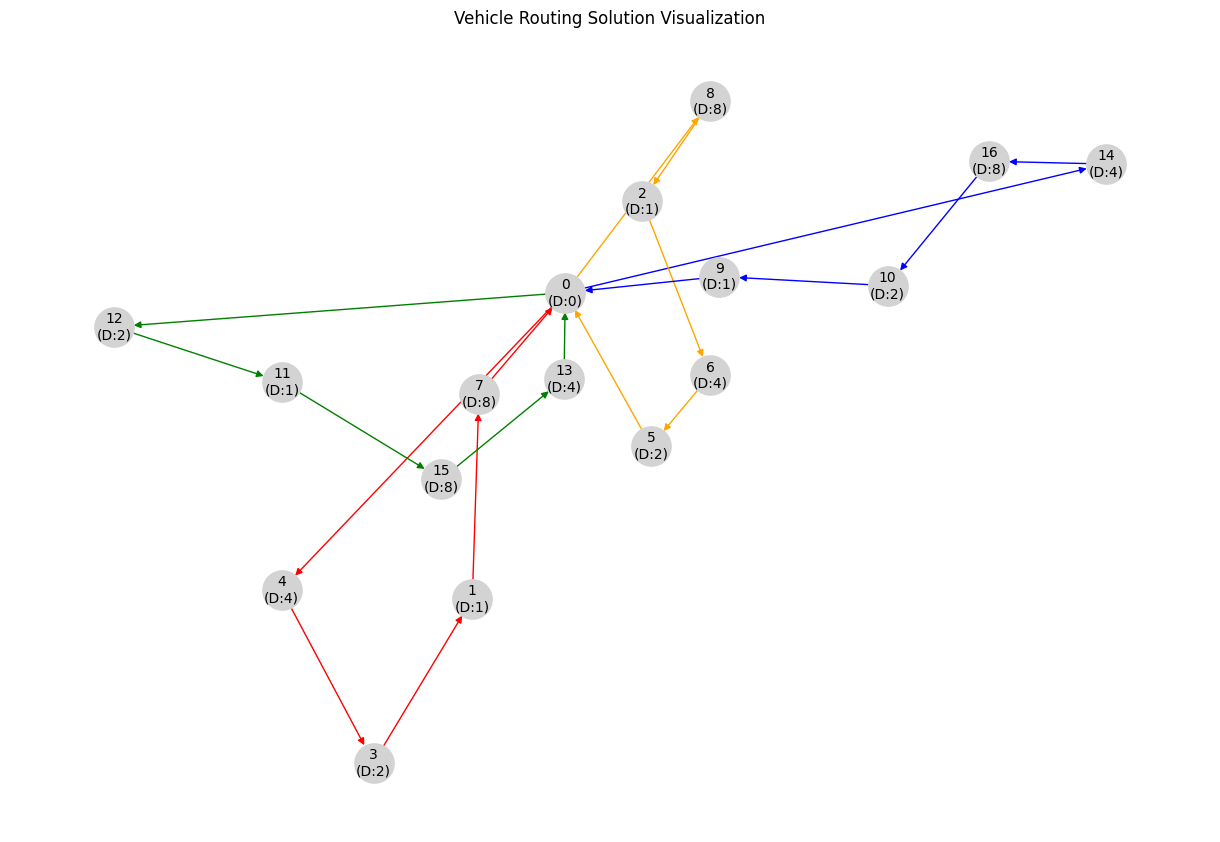

In [9]:
import matplotlib.pyplot as plt
import networkx as nx

# 데이터를 기반으로 생성된 경로 결과를 하드코딩
vehicle_routes = [
    [0, 4, 3, 1, 7, 0],  # Vehicle 0
    [0, 14, 16, 10, 9, 0],  # Vehicle 1
    [0, 12, 11, 15, 13, 0],  # Vehicle 2
    [0, 8, 2, 6, 5, 0],  # Vehicle 3
]

# 노드별 수요
demands = [0, 1, 1, 2, 4, 2, 4, 8, 8, 1, 2, 1, 2, 4, 4, 8, 8]

# 시각화를 위한 색상 설정
colors = ["red", "blue", "green", "orange"]

# 그래프 생성
G = nx.DiGraph()

# 노드 추가 및 라벨링 (수요 포함)
for i, demand in enumerate(demands):
    G.add_node(i, demand=demand)

# 경로 추가 및 색상 부여
for vehicle_id, route in enumerate(vehicle_routes):
    for i in range(len(route) - 1):
        G.add_edge(route[i], route[i + 1], color=colors[vehicle_id])

# 엣지 색상 추출
edges = G.edges()
edge_colors = [G[u][v]["color"] for u, v in edges]

# 그래프 레이아웃 설정
pos = nx.spring_layout(G, seed=42)

# 그래프 시각화
plt.figure(figsize=(12, 8))
nx.draw(
    G,
    pos,
    # with_labels=True,
    edge_color=edge_colors,
    node_color="lightgrey",
    node_size=800,
)

# 노드에 수요 정보 추가
demand_labels = {node: f"{node}\n(D:{data['demand']})" for node, data in G.nodes(data=True)}
nx.draw_networkx_labels(G, pos, labels=demand_labels, font_size=10)

plt.title("Vehicle Routing Solution Visualization")
plt.show()

픽업 및 배송 제약이 있는 차량 경로 문제

In [2]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = [
        # fmt: off
      [0, 548, 776, 696, 582, 274, 502, 194, 308, 194, 536, 502, 388, 354, 468, 776, 662],
      [548, 0, 684, 308, 194, 502, 730, 354, 696, 742, 1084, 594, 480, 674, 1016, 868, 1210],
      [776, 684, 0, 992, 878, 502, 274, 810, 468, 742, 400, 1278, 1164, 1130, 788, 1552, 754],
      [696, 308, 992, 0, 114, 650, 878, 502, 844, 890, 1232, 514, 628, 822, 1164, 560, 1358],
      [582, 194, 878, 114, 0, 536, 764, 388, 730, 776, 1118, 400, 514, 708, 1050, 674, 1244],
      [274, 502, 502, 650, 536, 0, 228, 308, 194, 240, 582, 776, 662, 628, 514, 1050, 708],
      [502, 730, 274, 878, 764, 228, 0, 536, 194, 468, 354, 1004, 890, 856, 514, 1278, 480],
      [194, 354, 810, 502, 388, 308, 536, 0, 342, 388, 730, 468, 354, 320, 662, 742, 856],
      [308, 696, 468, 844, 730, 194, 194, 342, 0, 274, 388, 810, 696, 662, 320, 1084, 514],
      [194, 742, 742, 890, 776, 240, 468, 388, 274, 0, 342, 536, 422, 388, 274, 810, 468],
      [536, 1084, 400, 1232, 1118, 582, 354, 730, 388, 342, 0, 878, 764, 730, 388, 1152, 354],
      [502, 594, 1278, 514, 400, 776, 1004, 468, 810, 536, 878, 0, 114, 308, 650, 274, 844],
      [388, 480, 1164, 628, 514, 662, 890, 354, 696, 422, 764, 114, 0, 194, 536, 388, 730],
      [354, 674, 1130, 822, 708, 628, 856, 320, 662, 388, 730, 308, 194, 0, 342, 422, 536],
      [468, 1016, 788, 1164, 1050, 514, 514, 662, 320, 274, 388, 650, 536, 342, 0, 764, 194],
      [776, 868, 1552, 560, 674, 1050, 1278, 742, 1084, 810, 1152, 274, 388, 422, 764, 0, 798],
      [662, 1210, 754, 1358, 1244, 708, 480, 856, 514, 468, 354, 844, 730, 536, 194, 798, 0],
        # fmt: on
    ]
    data["pickups_deliveries"] = [
        [1, 6],
        [2, 10],
        [4, 3],
        [5, 9],
        [7, 8],
        [15, 11],
        [13, 12],
        [16, 14],
    ]
    data["num_vehicles"] = 4
    data["depot"] = 0
    return data


def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    total_distance = 0
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += f" {manager.IndexToNode(index)} -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        plan_output += f"{manager.IndexToNode(index)}\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        print(plan_output)
        total_distance += route_distance
    print(f"Total Distance of all routes: {total_distance}m")


def main():
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Define cost of each arc.
    def distance_callback(from_index, to_index):
        """Returns the manhattan distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = "Distance"
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        3000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name,
    )
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Define Transportation Requests.
    for request in data["pickups_deliveries"]:
        pickup_index = manager.NodeToIndex(request[0])
        delivery_index = manager.NodeToIndex(request[1])
        routing.AddPickupAndDelivery(pickup_index, delivery_index)
        routing.solver().Add(
            routing.VehicleVar(pickup_index) == routing.VehicleVar(delivery_index)
        )
        routing.solver().Add(
            distance_dimension.CumulVar(pickup_index)
            <= distance_dimension.CumulVar(delivery_index)
        )

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PARALLEL_CHEAPEST_INSERTION
    )

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)


main()



Objective: 226116
Route for vehicle 0:
 0 ->  13 ->  15 ->  11 ->  12 -> 0
Distance of the route: 1552m

Route for vehicle 1:
 0 ->  5 ->  2 ->  10 ->  16 ->  14 ->  9 -> 0
Distance of the route: 2192m

Route for vehicle 2:
 0 ->  4 ->  3 -> 0
Distance of the route: 1392m

Route for vehicle 3:
 0 ->  7 ->  1 ->  6 ->  8 -> 0
Distance of the route: 1780m

Total Distance of all routes: 6916m


시간 제약이 있는 차량 경로 문제

In [3]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data["time_matrix"] = [
        [0, 6, 9, 8, 7, 3, 6, 2, 3, 2, 6, 6, 4, 4, 5, 9, 7],
        [6, 0, 8, 3, 2, 6, 8, 4, 8, 8, 13, 7, 5, 8, 12, 10, 14],
        [9, 8, 0, 11, 10, 6, 3, 9, 5, 8, 4, 15, 14, 13, 9, 18, 9],
        [8, 3, 11, 0, 1, 7, 10, 6, 10, 10, 14, 6, 7, 9, 14, 6, 16],
        [7, 2, 10, 1, 0, 6, 9, 4, 8, 9, 13, 4, 6, 8, 12, 8, 14],
        [3, 6, 6, 7, 6, 0, 2, 3, 2, 2, 7, 9, 7, 7, 6, 12, 8],
        [6, 8, 3, 10, 9, 2, 0, 6, 2, 5, 4, 12, 10, 10, 6, 15, 5],
        [2, 4, 9, 6, 4, 3, 6, 0, 4, 4, 8, 5, 4, 3, 7, 8, 10],
        [3, 8, 5, 10, 8, 2, 2, 4, 0, 3, 4, 9, 8, 7, 3, 13, 6],
        [2, 8, 8, 10, 9, 2, 5, 4, 3, 0, 4, 6, 5, 4, 3, 9, 5],
        [6, 13, 4, 14, 13, 7, 4, 8, 4, 4, 0, 10, 9, 8, 4, 13, 4],
        [6, 7, 15, 6, 4, 9, 12, 5, 9, 6, 10, 0, 1, 3, 7, 3, 10],
        [4, 5, 14, 7, 6, 7, 10, 4, 8, 5, 9, 1, 0, 2, 6, 4, 8],
        [4, 8, 13, 9, 8, 7, 10, 3, 7, 4, 8, 3, 2, 0, 4, 5, 6],
        [5, 12, 9, 14, 12, 6, 6, 7, 3, 3, 4, 7, 6, 4, 0, 9, 2],
        [9, 10, 18, 6, 8, 12, 15, 8, 13, 9, 13, 3, 4, 5, 9, 0, 9],
        [7, 14, 9, 16, 14, 8, 5, 10, 6, 5, 4, 10, 8, 6, 2, 9, 0],
    ]
    data["time_windows"] = [
        (0, 5),  # depot
        (7, 12),  # 1
        (10, 15),  # 2
        (16, 18),  # 3
        (10, 13),  # 4
        (0, 5),  # 5
        (5, 10),  # 6
        (0, 4),  # 7
        (5, 10),  # 8
        (0, 3),  # 9
        (10, 16),  # 10
        (10, 15),  # 11
        (0, 5),  # 12
        (5, 10),  # 13
        (7, 8),  # 14
        (10, 15),  # 15
        (11, 15),  # 16
    ]
    data["num_vehicles"] = 4
    data["depot"] = 0
    return data


def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    time_dimension = routing.GetDimensionOrDie("Time")
    total_time = 0
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        while not routing.IsEnd(index):
            time_var = time_dimension.CumulVar(index)
            plan_output += (
                f"{manager.IndexToNode(index)}"
                f" Time({solution.Min(time_var)},{solution.Max(time_var)})"
                " -> "
            )
            index = solution.Value(routing.NextVar(index))
        time_var = time_dimension.CumulVar(index)
        plan_output += (
            f"{manager.IndexToNode(index)}"
            f" Time({solution.Min(time_var)},{solution.Max(time_var)})\n"
        )
        plan_output += f"Time of the route: {solution.Min(time_var)}min\n"
        print(plan_output)
        total_time += solution.Min(time_var)
    print(f"Total time of all routes: {total_time}min")


def main():
    """Solve the VRP with time windows."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["time_matrix"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def time_callback(from_index, to_index):
        """Returns the travel time between the two nodes."""
        # Convert from routing variable Index to time matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["time_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(time_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Time Windows constraint.
    time = "Time"
    routing.AddDimension(
        transit_callback_index,
        30,  # allow waiting time
        30,  # maximum time per vehicle
        False,  # Don't force start cumul to zero.
        time,
    )
    time_dimension = routing.GetDimensionOrDie(time)
    # Add time window constraints for each location except depot.
    for location_idx, time_window in enumerate(data["time_windows"]):
        if location_idx == data["depot"]:
            continue
        index = manager.NodeToIndex(location_idx)
        time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])
    # Add time window constraints for each vehicle start node.
    depot_idx = data["depot"]
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        time_dimension.CumulVar(index).SetRange(
            data["time_windows"][depot_idx][0], data["time_windows"][depot_idx][1]
        )

    # Instantiate route start and end times to produce feasible times.
    for i in range(data["num_vehicles"]):
        routing.AddVariableMinimizedByFinalizer(
            time_dimension.CumulVar(routing.Start(i))
        )
        routing.AddVariableMinimizedByFinalizer(time_dimension.CumulVar(routing.End(i)))

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)


main()



Objective: 71
Route for vehicle 0:
0 Time(0,0) -> 9 Time(2,3) -> 14 Time(7,8) -> 16 Time(11,11) -> 0 Time(18,18)
Time of the route: 18min

Route for vehicle 1:
0 Time(0,0) -> 7 Time(2,4) -> 1 Time(7,11) -> 4 Time(10,13) -> 3 Time(16,16) -> 0 Time(24,24)
Time of the route: 24min

Route for vehicle 2:
0 Time(0,0) -> 12 Time(4,4) -> 13 Time(6,6) -> 15 Time(11,11) -> 11 Time(14,14) -> 0 Time(20,20)
Time of the route: 20min

Route for vehicle 3:
0 Time(0,0) -> 5 Time(3,3) -> 8 Time(5,5) -> 6 Time(7,7) -> 2 Time(10,10) -> 10 Time(14,14) -> 0 Time(20,20)
Time of the route: 20min

Total time of all routes: 82min
